# Шаг 1. Загрузка необходимых библиотек

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.special import inv_boxcox

# Шаг 2. Загрузка необходимого датасета по стоимостям машин из Kaggle

In [188]:
#!mkdir -p ~/.kaggle/ # создать .kaggle папку на диске

In [189]:
#!gdown --id 1ITV6ymlFBy5wTOxgTmRH4HrocTw1C7jC # загрузка файла с моего диска. Тут вход на тестовый аккаунт преподавателя. Вам нужен ваш аккаунт

# https://drive.google.com/file/d/1ITV6ymlFBy5wTOxgTmRH4HrocTw1C7jC/view?usp=sharing

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ITV6ymlFBy5wTOxgTmRH4HrocTw1C7jC
To: /content/kaggle.json
100% 74.0/74.0 [00:00<00:00, 293kB/s]


In [190]:
#!cp /content/kaggle.json ~/.kaggle

In [191]:
#!chmod 600 /root/.kaggle/kaggle.json

In [192]:
#!kaggle datasets download -d nehalbirla/vehicle-dataset-from-cardekho #датасет прогноза погоды

#https://www.kaggle.com/datasets/zalando-research/fashionmnist

vehicle-dataset-from-cardekho.zip: Skipping, found more recently modified local copy (use --force to force download)


In [193]:
#!unzip vehicle-dataset-from-cardekho.zip

Archive:  vehicle-dataset-from-cardekho.zip
replace CAR DETAILS FROM CAR DEKHO.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Шаг 3. Чтение Датасета

In [194]:
df = pd.read_csv('car data.csv')

# Шаг 4. Визуализация датасета

In [195]:
df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


В данном случае целевой прогнозируемой переменной будет являться "Selling Price"

In [196]:
df.shape

(301, 9)

Датасет состоит из 301 строки и 9 столбцов

Основная информация по датасету

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


Нет пустых значений

Обзор колонок с численными значениями

In [198]:
df.describe(include='number')

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


Обзор колонок с нечисленными значениями

In [199]:
df.describe(include='object')

,Car_Name,Fuel_Type,Seller_Type,Transmission
count,301,301,301,301
unique,98,3,2,2
top,city,Petrol,Dealer,Manual
freq,26,239,195,261


# Шаг 5. Подготовка данных

In [200]:
df['Car_Name'].nunique()

98

98 уникальных значений машин. Рекомендуется убрать эти данные из датасета

In [201]:
df.drop('Car_Name', axis=1, inplace=True)

Вместо года проведем разбалловку где минимальное значение 1 примет 2003 год, а максимальный 2018 максмимальный балл

In [202]:
df.insert(0, "Age", df["Year"].max()+1-df["Year"] )
df.drop('Year', axis=1, inplace=True)
df.head()

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,5,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,6,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,8,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,5,4.60,6.87,42450,Diesel,Dealer,Manual,0


Рассмотрим данные на выбросы

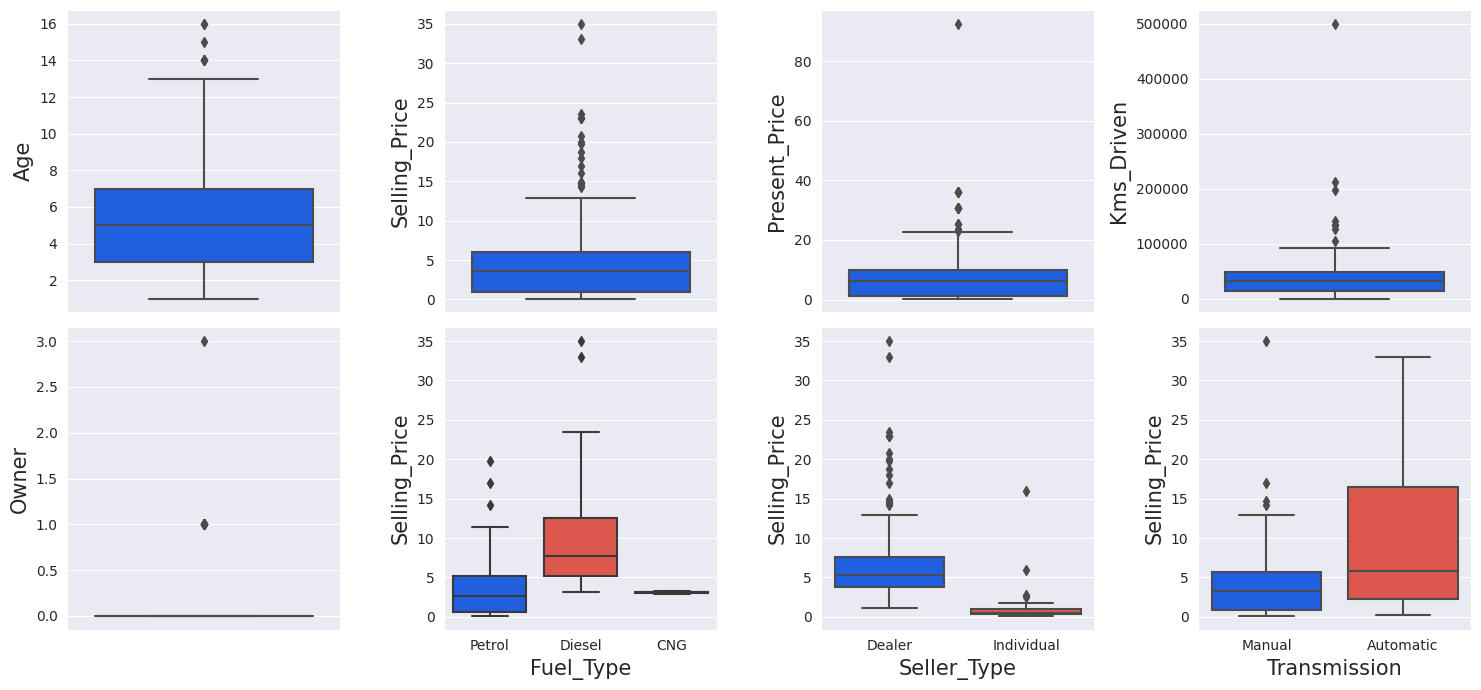

In [203]:
sns.set_style('darkgrid')
colors = ['#0055ff', '#f44336', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

OrderedCols = np.concatenate([df.select_dtypes(exclude='object').columns.values,
                              df.select_dtypes(include='object').columns.values])

fig, ax = plt.subplots(2, 4, figsize=(15,7),dpi=100)

for i,col in enumerate(OrderedCols):
    x = i//4
    y = i%4
    if i<5:
        sns.boxplot(data=df, y=col, ax=ax[x,y])
        ax[x,y].yaxis.label.set_size(15)
    else:
        sns.boxplot(data=df, x=col, y='Selling_Price', ax=ax[x,y])
        ax[x,y].xaxis.label.set_size(15)
        ax[x,y].yaxis.label.set_size(15)

plt.tight_layout()
plt.show()

In [204]:
outliers_indexes = []
target = 'Selling_Price'

for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())


for col in df.select_dtypes(exclude='object').columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())

outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

38 outliers were identified, whose indices are:

[27, 37, 39, 50, 51, 52, 53, 54, 179, 184, 58, 59, 189, 62, 63, 64, 191, 66, 192, 196, 69, 193, 198, 201, 77, 205, 79, 80, 82, 84, 85, 86, 92, 93, 96, 97, 106, 241]


Недопустимо отбрасывать наблюдение только потому, что оно является выбросом. Они могут быть законными наблюдениями, и важно изучить природу выброса, прежде чем принимать решение о том, удалять его или нет. Удалять выбросы разрешается в двух случаях:

Выброс обусловлен неверно введенными или измеренными данными

Выброс создает значимую ассоциацию

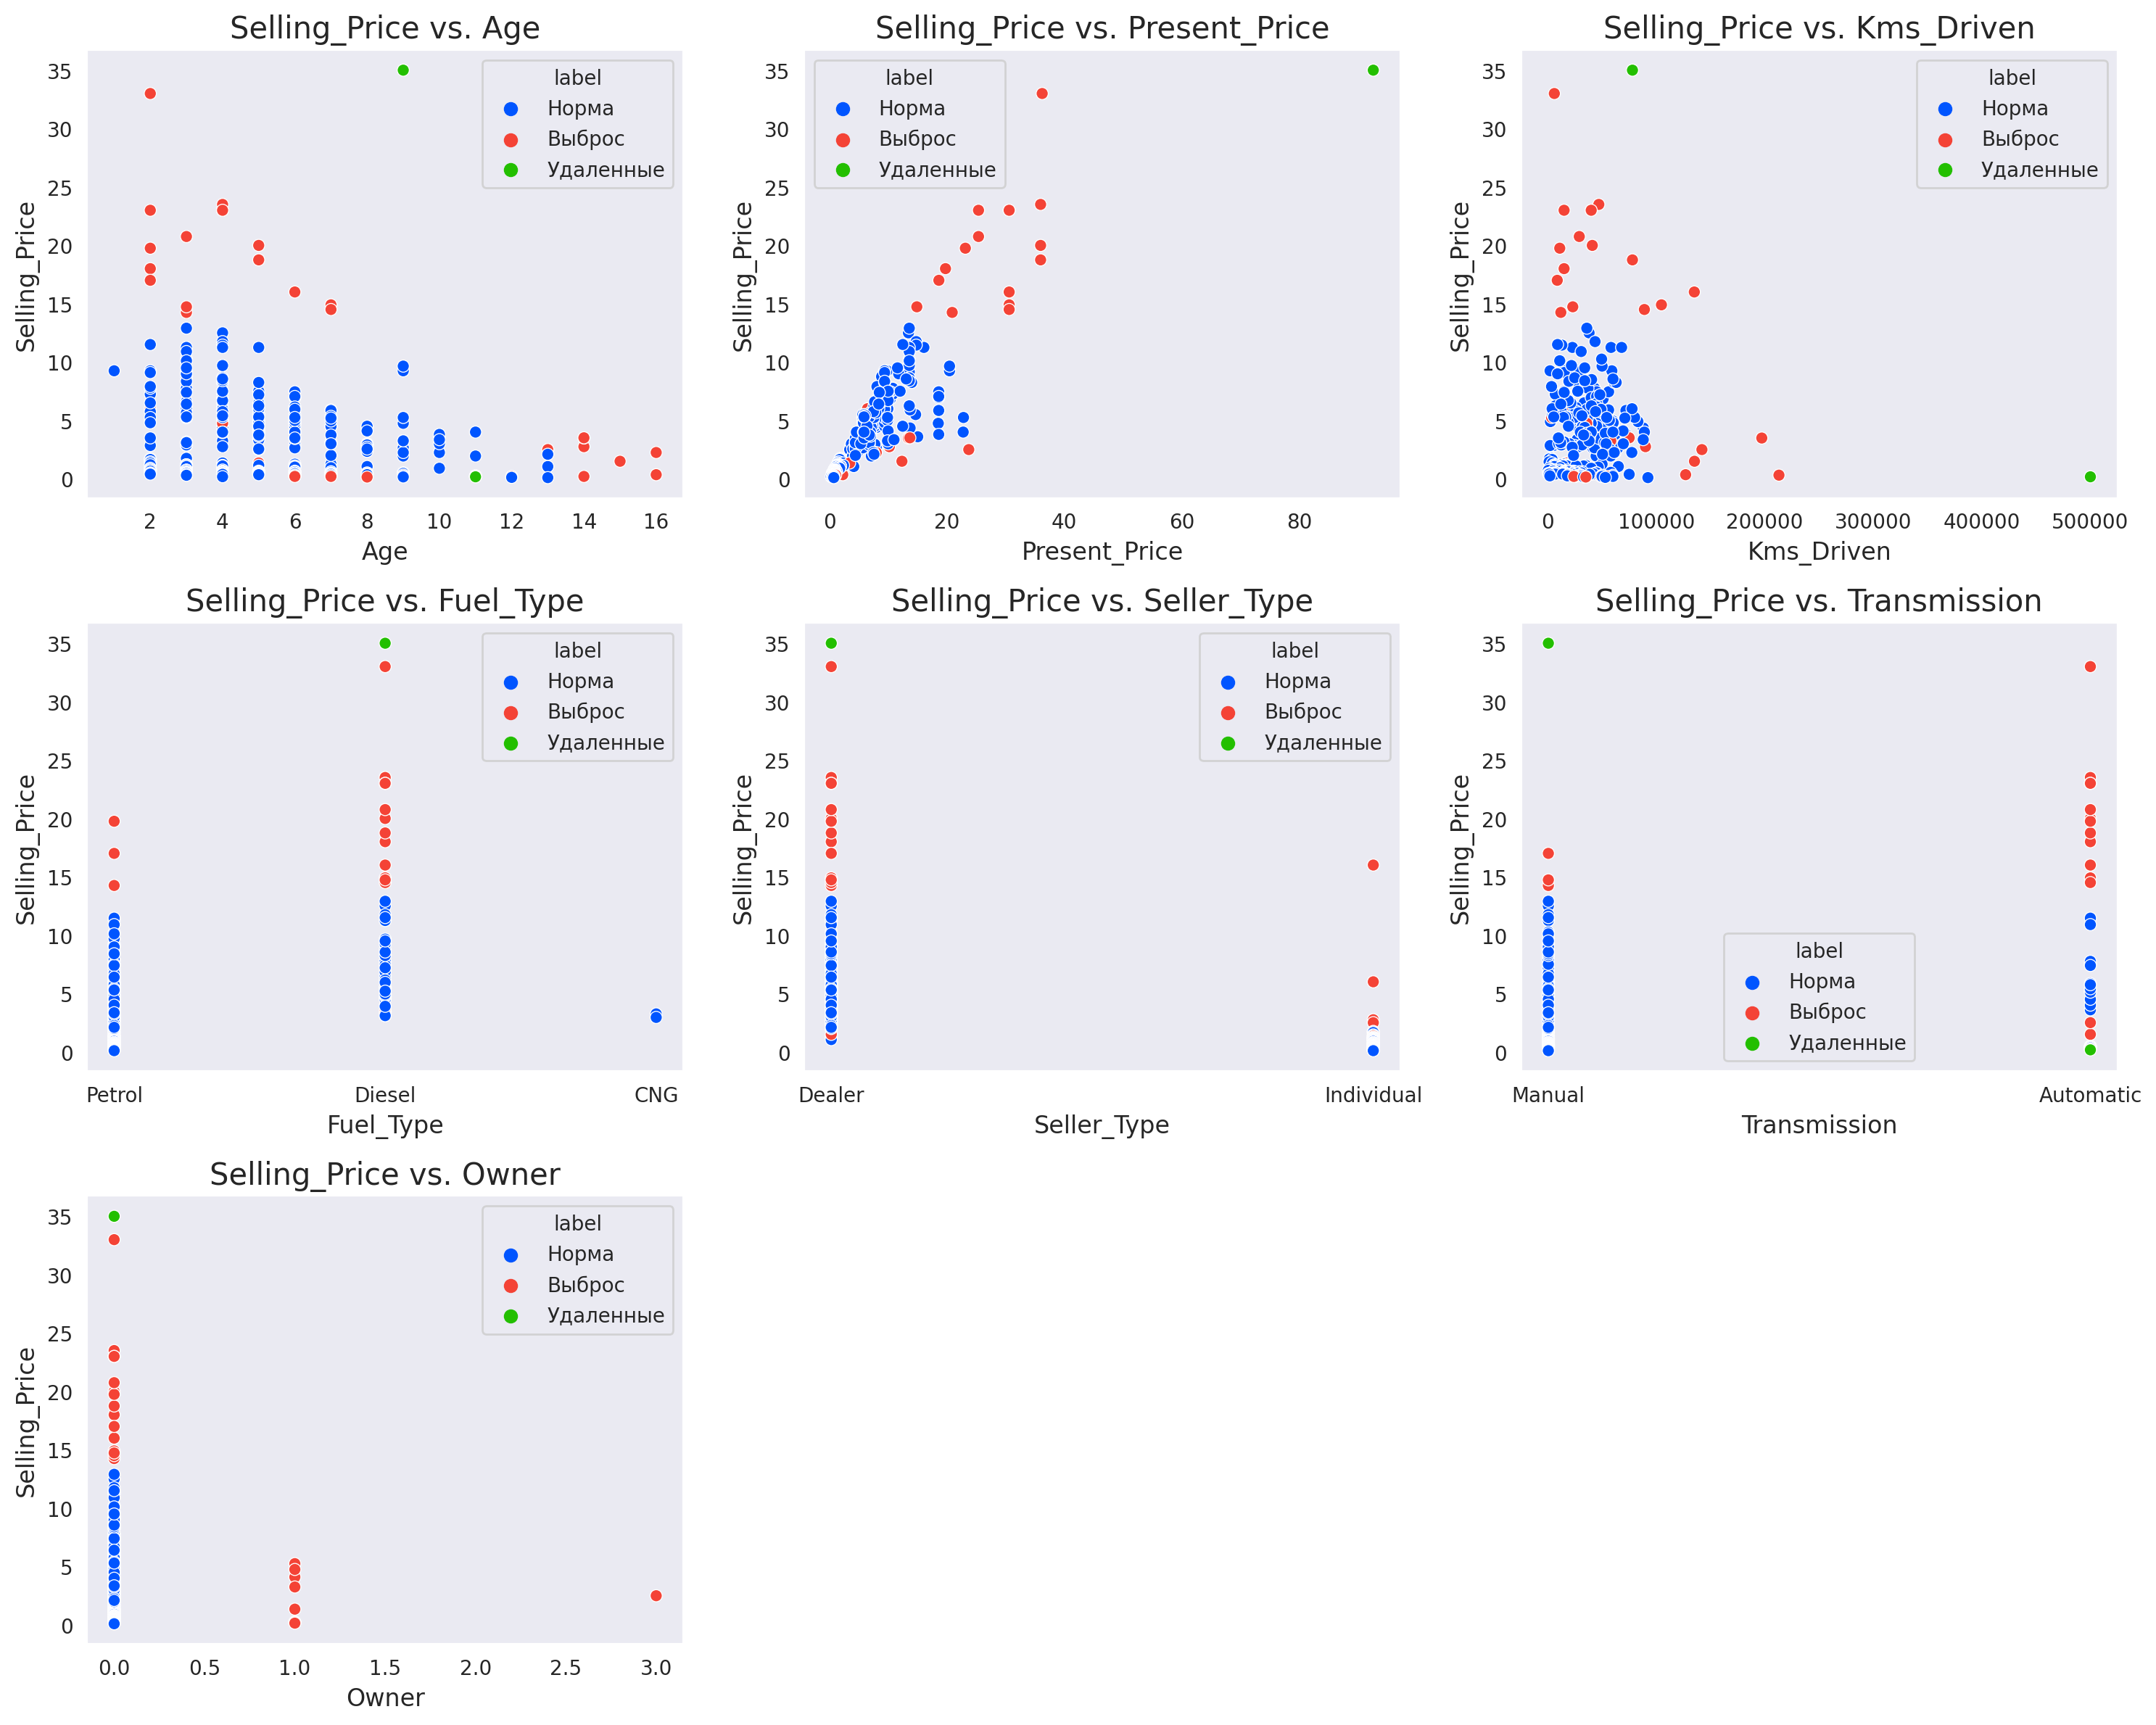

In [205]:
# Outliers labeling
df1 = df.copy()
df1['label'] = 'Норма'
df1.loc[outliers_indexes,'label'] = 'Выброс'

# Removing Outliers
removing_indexes = []
removing_indexes.extend(df1[df1[target]>33].index)
removing_indexes.extend(df1[df1['Kms_Driven']>400000].index)
df1.loc[removing_indexes,'label'] = 'Удаленные'

# Plot
target = 'Selling_Price'
features = df.columns.drop(target)
colors = ['#0055ff','#f44336','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3 ,ncols=3, figsize=(15,12), dpi=200)

for i in range(len(features)):
    x=i//3
    y=i%3
    sns.scatterplot(data=df1, x=features[i], y=target, hue='label', ax=ax[x,y])
    ax[x,y].set_title('{} vs. {}'.format(target, features[i]), size = 15)
    ax[x,y].set_xlabel(features[i], size = 12)
    ax[x,y].set_ylabel(target, size = 12)
    ax[x,y].grid()

ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

Удаляемые выбросы будут связаны со следующими показателями:

In [206]:
removing_indexes = list(set(removing_indexes))
removing_indexes

[196, 86]

Эти две выборки сильно отличаются от общей картины, наблюдаемой на диаграммах рассеяния данных. Поскольку линейная регрессия чувствительна к выбросам, мы отбросим их.

Поиск пропущенных значений

In [207]:
df.isnull().sum()

Age              0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

Поиск дублей

In [208]:
df[df.duplicated(keep=False)]

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
15,3,7.75,10.79,43000,Diesel,Dealer,Manual,0
17,3,7.75,10.79,43000,Diesel,Dealer,Manual,0
51,4,23.00,30.61,40000,Diesel,Dealer,Automatic,0
93,4,23.00,30.61,40000,Diesel,Dealer,Automatic,0


Поскольку возможны автомобили с одинаковыми характеристиками, мы не отбрасываем дубликаты.

Удаляем лишнее

In [209]:
df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)

# Шаг 6. Разведочный анализ данных

Анализ категориальных переменных

In [210]:
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

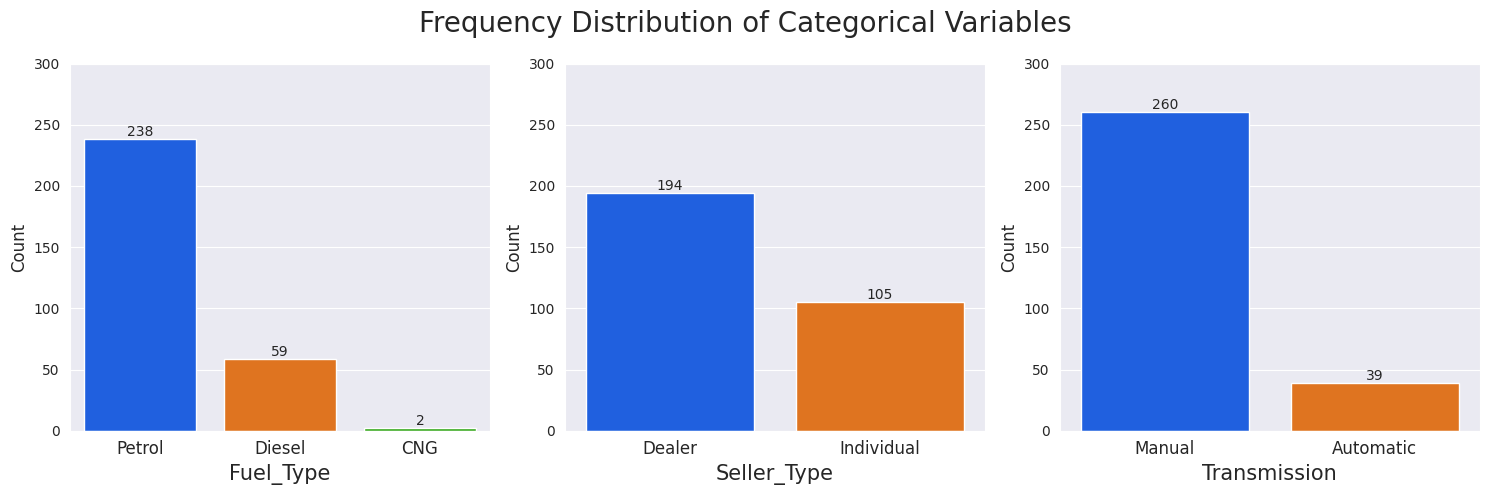

In [211]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), dpi=100)
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

for i in range(len(CatCols)):
    graph = sns.countplot(x=CatCols[i], data=df1, ax=ax[i])
    ax[i].set_xlabel(CatCols[i], fontsize=15)
    ax[i].set_ylabel('Count', fontsize=12)
    ax[i].set_ylim([0,300])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12)
    for cont in graph.containers:
        graph.bar_label(cont)

plt.suptitle('Frequency Distribution of Categorical Variables', fontsize=20)
plt.tight_layout()
plt.show()

Вывод:
Существует 3 категории Fuel_Type. Наибольшую частоту встречаемости имеет бензин, наименьшую - КПГ.
Существует 2 категории типа продавца. Наибольшая частота встречается у дилера, наименьшая - у частного лица.
Существует 2 категории трансмиссии. Наибольшая частота встречается у механической коробки передач, наименьшая - у автоматической.

Анализ численных переменных

In [212]:
NumCols = ['Age', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']

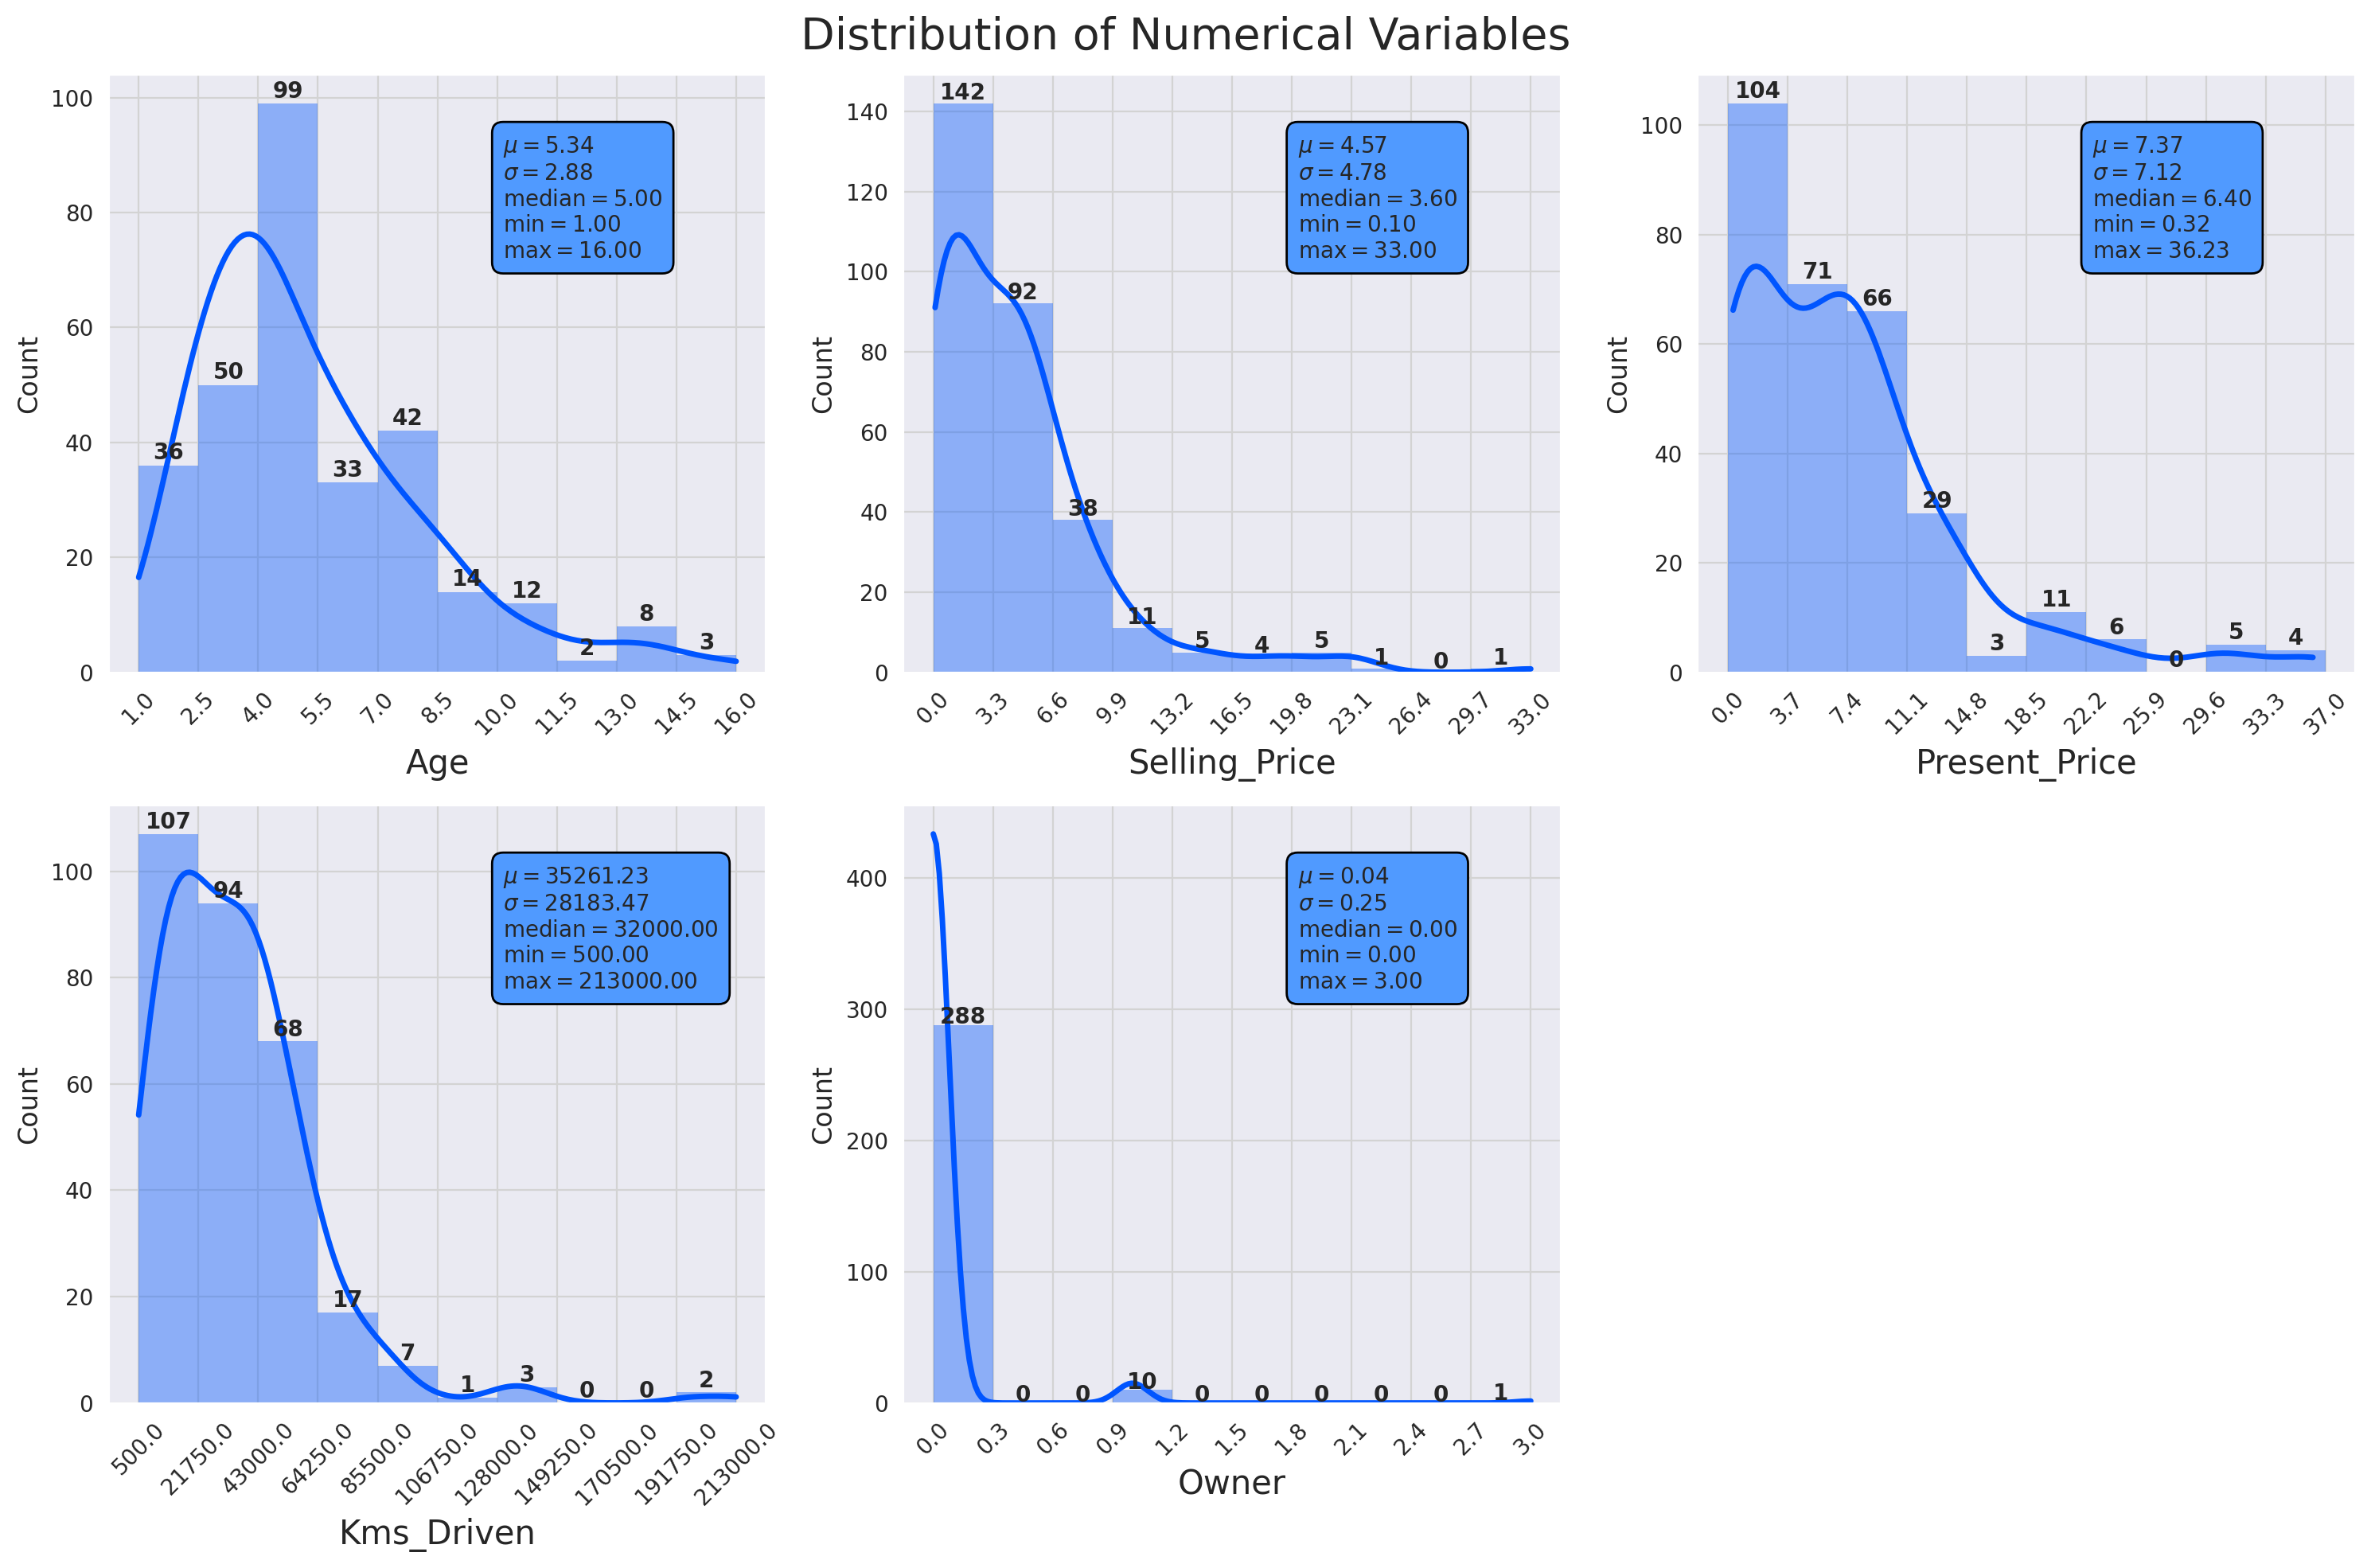

In [213]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), dpi=200)
c = '#0055ff'

for i in range(len(NumCols)):
    row = i//3
    col = i%3
    values, bin_edges = np.histogram(df1[NumCols[i]],
                                     range=(np.floor(df1[NumCols[i]].min()), np.ceil(df1[NumCols[i]].max())))
    graph = sns.histplot(data=df1, x=NumCols[i], bins=bin_edges, kde=True, ax=ax[row,col],
                         edgecolor='none', color=c, alpha=0.4, line_kws={'lw': 2.5})
    ax[row,col].set_xlabel(NumCols[i], fontsize=15)
    ax[row,col].set_ylabel('Count', fontsize=12)
    ax[row,col].set_xticks(np.round(bin_edges,1))
    ax[row,col].set_xticklabels(ax[row,col].get_xticks(), rotation = 45)
    ax[row,col].grid(color='lightgrey')
    for j,p in enumerate(graph.patches):
        ax[row,col].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1),
                             ha='center', fontsize=10 ,fontweight="bold")

    textstr = '\n'.join((
    r'$\mu=%.2f$' %df1[NumCols[i]].mean(),
    r'$\sigma=%.2f$' %df1[NumCols[i]].std(),
    r'$\mathrm{median}=%.2f$' %np.median(df1[NumCols[i]]),
    r'$\mathrm{min}=%.2f$' %df1[NumCols[i]].min(),
    r'$\mathrm{max}=%.2f$' %df1[NumCols[i]].max()
    ))
    ax[row,col].text(0.6, 0.9, textstr, transform=ax[row,col].transAxes, fontsize=10, verticalalignment='top',
                     bbox=dict(boxstyle='round',facecolor='#509aff', edgecolor='black', pad=0.5))

ax[1, 2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20)
plt.tight_layout()
plt.show()

# Шаг 7. Кодирование категориальных переменных

In [214]:
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)
df1.head(5)

,Age,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,5,3.35,5.59,27000,0,0,1,0,1
1,6,4.75,9.54,43000,0,1,0,0,1
2,2,7.25,9.85,6900,0,0,1,0,1
3,8,2.85,4.15,5200,0,0,1,0,1
4,5,4.60,6.87,42450,0,1,0,0,1


# Шаг 8. Анализ корреляций

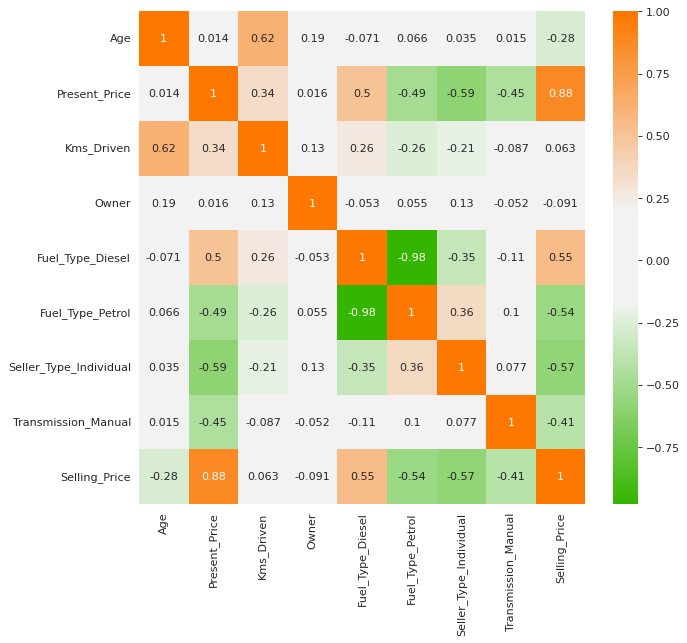

In [215]:
target = 'Selling_Price'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)
ax = sns.heatmap(pd.concat([df1.drop(target,axis=1), df1[target]],axis=1).corr(), annot=True, cmap=cmap)
plt.show()

Целевая переменная "Цена продажи" сильно коррелирует с Present_Price, Seller_Type и Fuel_Type.
Некоторые независимые переменные, такие как Fuel_Type_Petrol и Fuel_Type_Disel, сильно коррелируют между собой, что называется мультиколлинеарностью.

# Шаг 9. Построение модели Линейной Регрессии

In [216]:
X = df1.drop('Selling_Price', axis=1)
y = df1['Selling_Price']

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

In [218]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (209, 8)
X_test shape:  (90, 8)
y_train shape:  (209,)
y_test shape:  (90,)


In [219]:
print(X_train)
print(y_train)

     Age  Present_Price  Kms_Driven  Owner  Fuel_Type_Diesel  \
287    3          13.60       10980      0                 0   
262    4           7.00       40026      0                 0   
195    9           0.51       33000      0                 0   
77    15          12.35      135154      0                 0   
15     3          10.79       43000      0                 1   
..   ...            ...         ...    ...               ...   
188   14           0.57       55000      0                 0   
120    8           1.50        6900      0                 0   
48     4           7.71       25870      0                 0   
260    4           5.80       40023      0                 0   
207    4           5.70       21125      0                 1   

     Fuel_Type_Petrol  Seller_Type_Individual  Transmission_Manual  
287                 1                       0                    1  
262                 1                       0                    1  
195                 1   

In [220]:
y_test_actual = y_test

Маштабирование данных с помощью StandartScaler

In [221]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Очень важно, что преобразования StandardScaler должны обучаться только на обучающем множестве, иначе это приведет к утечке данных.

Обучение модели

In [222]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

LinearRegression()

Оценка модели

In [223]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    # Plotting Graphs
    # Residual Plot of train data
    fig, ax = plt.subplots()


    # Y_test vs Y_train scatter plot
    ax.set_title('y_true vs y_predicted')
    ax.scatter(x = y_test, y = y_pred)
    ax.set_xlabel('y_true')
    ax.set_ylabel('y_predicted')


    plt.show()

    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

Результаты моделирования тренировочной выборки

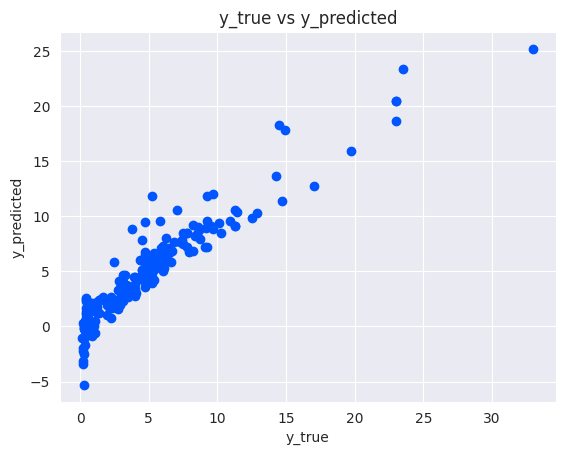

,Linear Reg.
MAE,1.095627
MSE,2.613962
RMSE,1.616775
R2-Score,0.891030


In [224]:
model_evaluation(linear_reg, X_train_scaled, y_train, 'Linear Reg.')

Результаты моделирования тестовой выборки

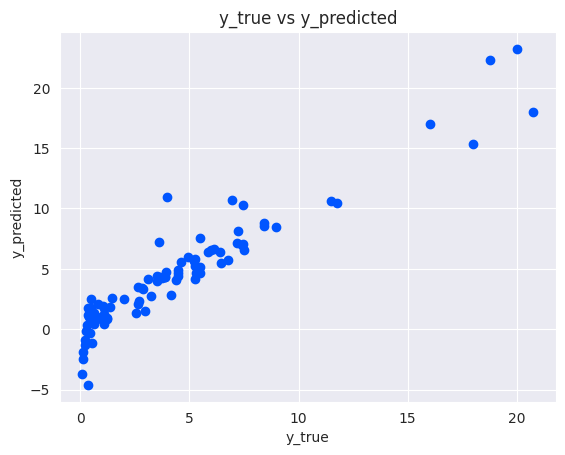

,Linear Reg.
MAE,1.062844
MSE,2.473008
RMSE,1.572580
R2-Score,0.875331


In [225]:
model_evaluation(linear_reg, X_test_scaled, y_test, 'Linear Reg.')

Оценка модели с помощью кросс-валидации

Использование перекрестной валидации позволяет нам с большей уверенностью оценивать метрики оценки модели, чем прежнее простое разделение "обучение-тестирование":

In [226]:
linear_reg_cv = LinearRegression()
scaler = StandardScaler()
pipeline = make_pipeline(StandardScaler(),  LinearRegression())

kf = KFold(n_splits=6, shuffle=True, random_state=0)
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
MAE_std = (-result['test_neg_mean_absolute_error']).std()
MSE_mean = (-result['test_neg_mean_squared_error']).mean()
MSE_std = (-result['test_neg_mean_squared_error']).std()
RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result['test_r2'].mean()
R2_Score_std = result['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,R2_Score_std]},
             index=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

,Mean,Std
MAE,1.154774,0.147377
MSE,3.131755,1.314319
RMSE,1.728702,0.378609
R2-Score,0.855703,0.033720


Модель линейной регрессии получила R2-score %85,57 при использовании 6-кратной кросс-валидации.

Конвейер - отличный способ предотвратить утечку данных, поскольку он гарантирует, что соответствующий метод будет выполняться на правильном подмножестве данных. Он идеально подходит для использования в кросс-валидации, поскольку гарантирует, что при выполнении подгонки используются только обучающие складки, а тестовое (валидационное) множество используется только для вычисления оценки точности на каждой итерации кросс-валидации

# Шаг 10. Регрессия Лассо

In [227]:
lasso_cv_model = LassoCV(eps=0.01, n_alphas=100, max_iter=10000, cv=3)

In [228]:
lasso_cv_model.fit(X_train_scaled, y_train)

LassoCV(cv=3, eps=0.01, max_iter=10000)

In [229]:
lasso_cv_model.alpha_

0.05966378750768516

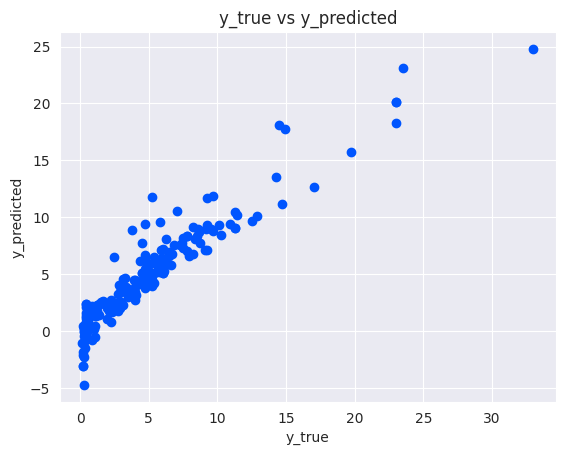

,Lasso Reg. Train
MAE,1.095722
MSE,2.632408
RMSE,1.622470
R2-Score,0.890261


In [230]:
model_evaluation(lasso_cv_model, X_train_scaled, y_train, 'Lasso Reg. Train')

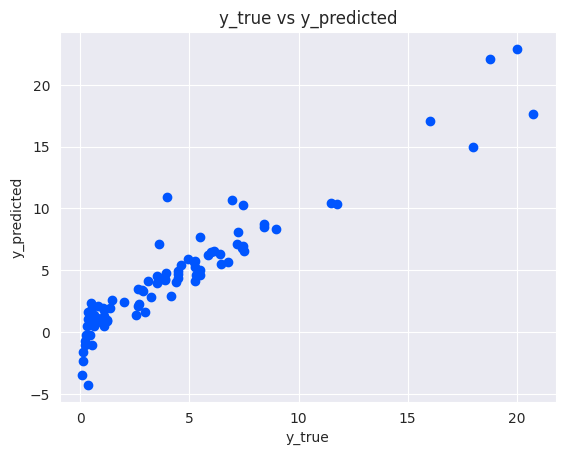

,Lasso Reg. Test
MAE,1.050508
MSE,2.370931
RMSE,1.539783
R2-Score,0.880477


In [231]:
model_evaluation(lasso_cv_model, X_test_scaled, y_test, 'Lasso Reg. Test')

# Шаг 11. Построение модели Регресии Ридж

In [232]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge_cv_model = RidgeCV(alphas = alphas, cv = 3, scoring = 'neg_mean_squared_error')
ridge_cv_model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+0...
       3.06795364e+00, 2.32079442e+00, 1.75559587e+00, 1.32804389e+00,
       1.00461650e+00, 7.59955541e-01, 5.74878498e-01, 4.34874501e-01,
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03]),
        cv=3, scoring='neg_mean_squared_error')

In [233]:
ridge_cv_model.alpha_

7.087370814634009

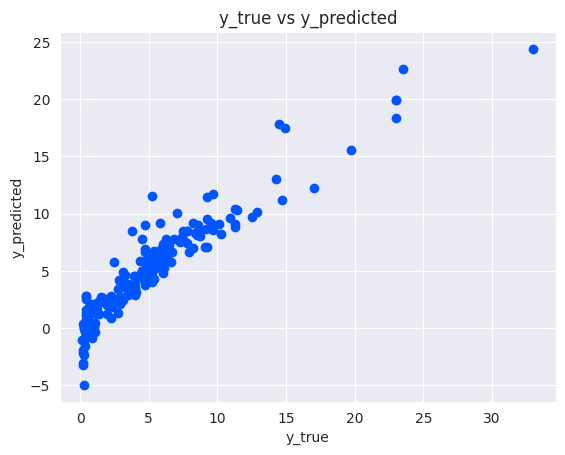

,Ridge Reg. Test
MAE,1.104892
MSE,2.654507
RMSE,1.629266
R2-Score,0.889340


In [234]:
model_evaluation(ridge_cv_model, X_train_scaled, y_train, 'Ridge Reg. Test')

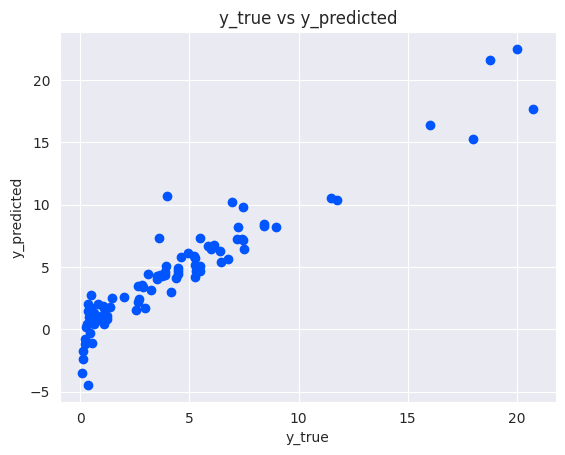

,Ridge Reg. Test
MAE,1.031622
MSE,2.284965
RMSE,1.511610
R2-Score,0.884811


In [235]:
model_evaluation(ridge_cv_model, X_test_scaled, y_test, 'Ridge Reg. Test')

# Шаг 12. Построение модели Случайного Леса

In [236]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

# Number of trees in Random forest
n_estimators=list(range(500,1000,100))
# Maximum number of levels in a tree
max_depth=list(range(4,9,4))
# Minimum number of samples required to split an internal node
min_samples_split=list(range(4,9,2))
# Minimum number of samples required to be at a leaf node.
min_samples_leaf=[1,2,5,7]
# Number of fearures to be considered at each split
max_features=['auto','sqrt']

# Hyperparameters dict
param_grid = {"n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf,
              "max_features":max_features}

rf_rs = RandomizedSearchCV(estimator = rf, param_distributions = param_grid)

In [237]:
rf_rs.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [4, 8],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 7],
                                        'min_samples_split': [4, 6, 8],
                                        'n_estimators': [500, 600, 700, 800,
                                                         900]})

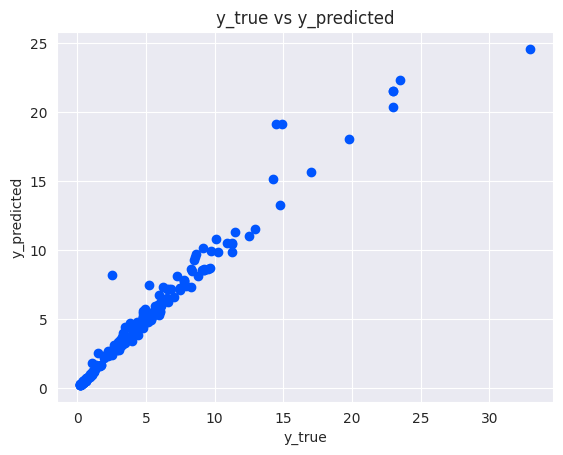

,Random Forest
MAE,0.425419
MSE,0.956266
RMSE,0.977889
R2-Score,0.960135


In [238]:
model_evaluation(rf_rs, X_train_scaled, y_train, 'Random Forest')

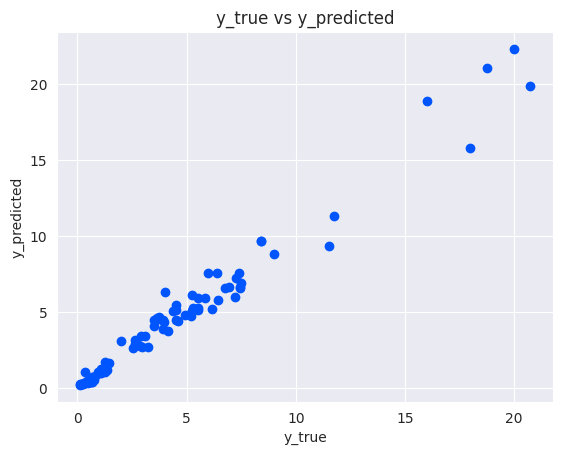

,Random Forest
MAE,0.512631
MSE,0.654021
RMSE,0.808715
R2-Score,0.967030


In [239]:
model_evaluation(rf_rs, X_test_scaled, y_test, 'Random Forest')

In [240]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

gb = GradientBoostingRegressor()

# Rate at which correcting is being made
learning_rate = [0.001, 0.01, 0.1, 0.2]
# Number of trees in Gradient boosting
n_estimators=list(range(500,1000,100))
# Maximum number of levels in a tree
max_depth=list(range(4,9,4))
# Minimum number of samples required to split an internal node
min_samples_split=list(range(4,9,2))
# Minimum number of samples required to be at a leaf node.
min_samples_leaf=[1,2,5,7]
# Number of fearures to be considered at each split
max_features=['auto','sqrt']

# Hyperparameters dict
param_grid = {"learning_rate":learning_rate,
              "n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf,
              "max_features":max_features}

gb_rs = RandomizedSearchCV(estimator = gb, param_distributions = param_grid)

In [241]:
gb_rs.fit(X_train_scaled, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

RandomizedSearchCV(estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'max_depth': [4, 8],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 7],
                                        'min_samples_split': [4, 6, 8],
                                        'n_estimators': [500, 600, 700, 800,
                                                         900]})

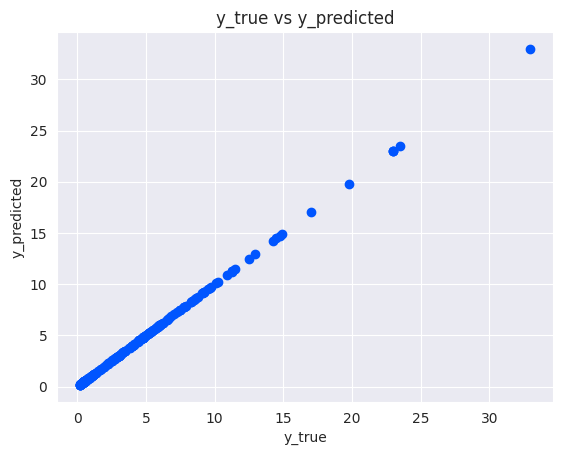

,Gradient Boosting
MAE,0.008325
MSE,0.000148
RMSE,0.012185
R2-Score,0.999994


In [242]:
model_evaluation(gb_rs, X_train_scaled, y_train, 'Gradient Boosting')

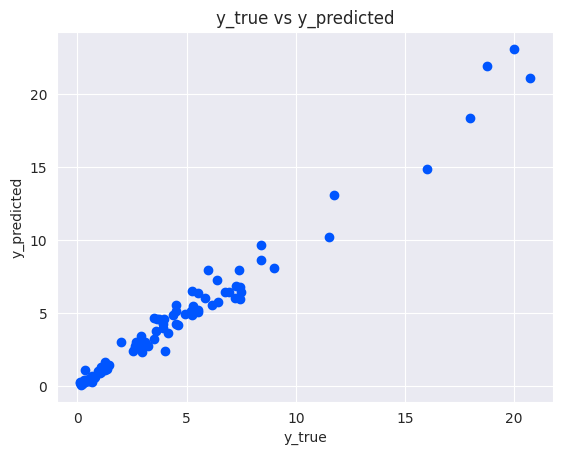

,Gradient Boosting
MAE,0.496979
MSE,0.592024
RMSE,0.769431
R2-Score,0.970155


In [243]:
model_evaluation(gb_rs, X_test_scaled, y_test, 'Gradient Boosting')

In [244]:
import csv
print(X_train_scaled)
with open('product_sales.csv', 'w', newline='') as file:
    # Шаг 4: используем метод csv.writer, чтобы сохранить список в файл формата CSV
    writer = csv.writer(file)
    writer.writerows(X_train_scaled) # Use writerows for nested list

[[-0.76985919  0.88044783 -0.82754641 ...  0.50895594 -0.72494651
   0.37693037]
 [-0.43112115 -0.06467743  0.16541821 ...  0.50895594 -0.72494651
   0.37693037]
 [ 1.26256907 -0.99405059 -0.07477216 ...  0.50895594  1.37941211
   0.37693037]
 ...
 [-0.43112115  0.03699514 -0.31851786 ...  0.50895594 -0.72494651
   0.37693037]
 [-0.43112115 -0.23651838  0.16531565 ...  0.50895594 -0.72494651
   0.37693037]
 [-0.43112115 -0.25083846 -0.48073012 ... -1.96480664 -0.72494651
   0.37693037]]


In [245]:
y_test_pred = linear_reg.predict(X_test_scaled)
df_comp = pd.DataFrame({'Actual':y_test_actual, 'Predicted':y_test_pred})
y_test_pred_2 = rf_rs.predict(X_test_scaled)
y_test_pred_3 = gb_rs.predict(X_test_scaled)
y_test_pred_4 = ridge_cv_model.predict(X_test_scaled)
df_comp_2 = pd.DataFrame({'Actual':y_test_actual, 'Predicted':y_test_pred_2})
df_comp_3 = pd.DataFrame({'Actual':y_test_actual, 'Predicted':y_test_pred_3})
df_comp_4 = pd.DataFrame({'Actual':y_test_actual, 'Predicted':y_test_pred_4})

In [246]:
def compare_plot(df_comp, name):
    df_comp.reset_index(inplace=True)
    df_comp.plot(y=['Actual','Predicted'], kind='bar', figsize=(20,7), width=0.8)
    plt.title('Predicted vs. Actual Target Values for Test Data with '+ name, fontsize=20)
    plt.ylabel('Selling_Price', fontsize=15)
    plt.show()

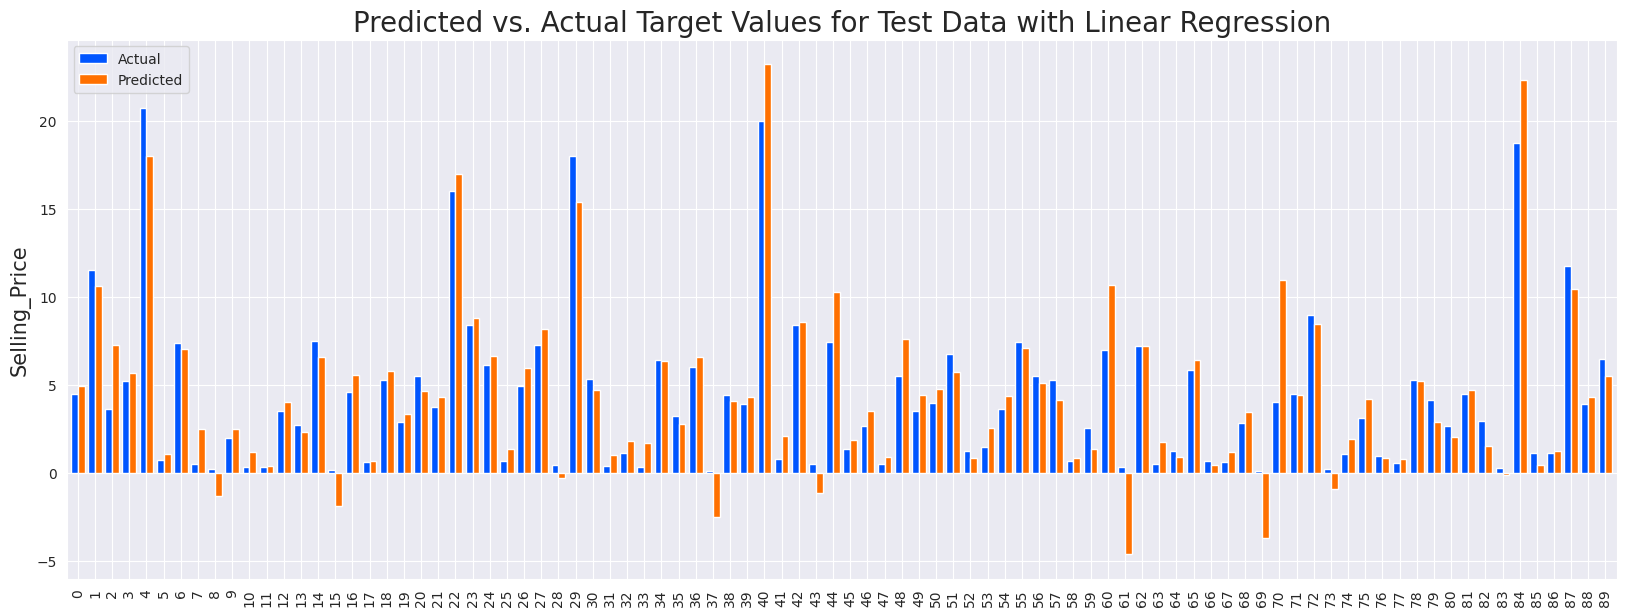

In [247]:
compare_plot(df_comp, "Linear Regression")

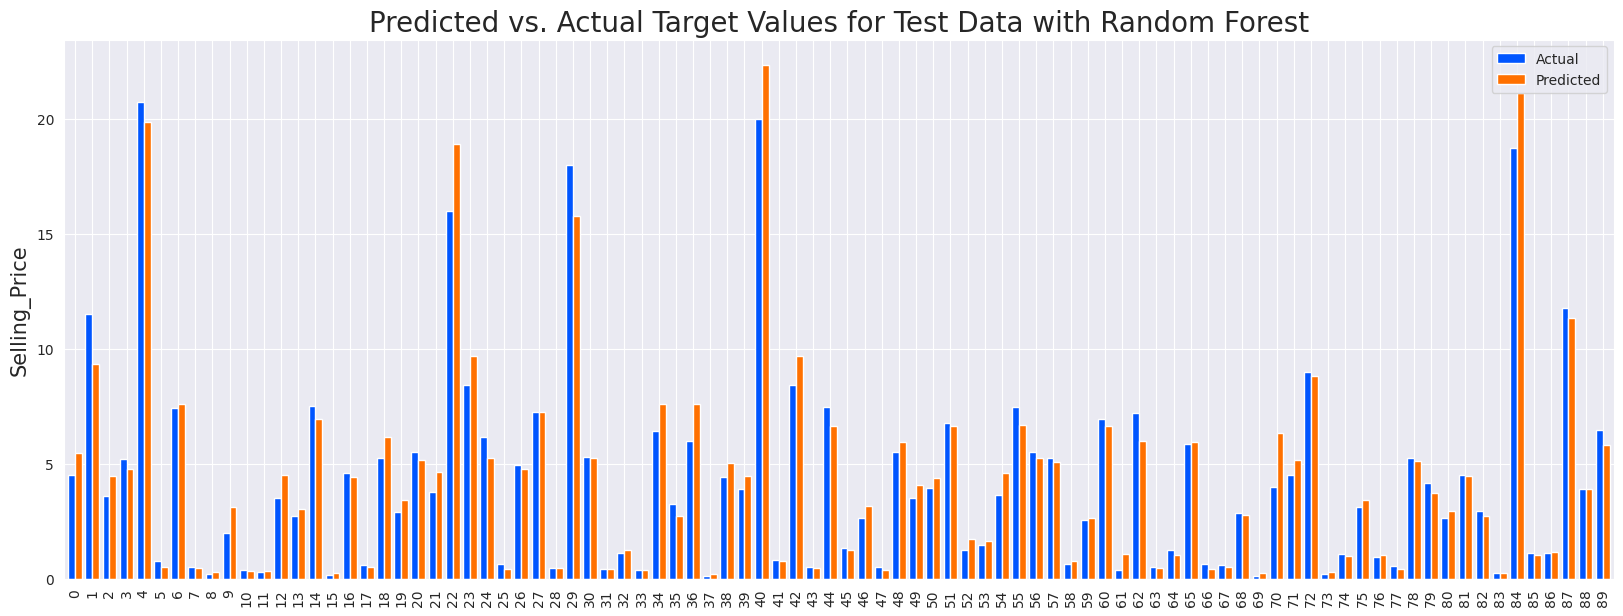

In [248]:
compare_plot(df_comp_2, "Random Forest")

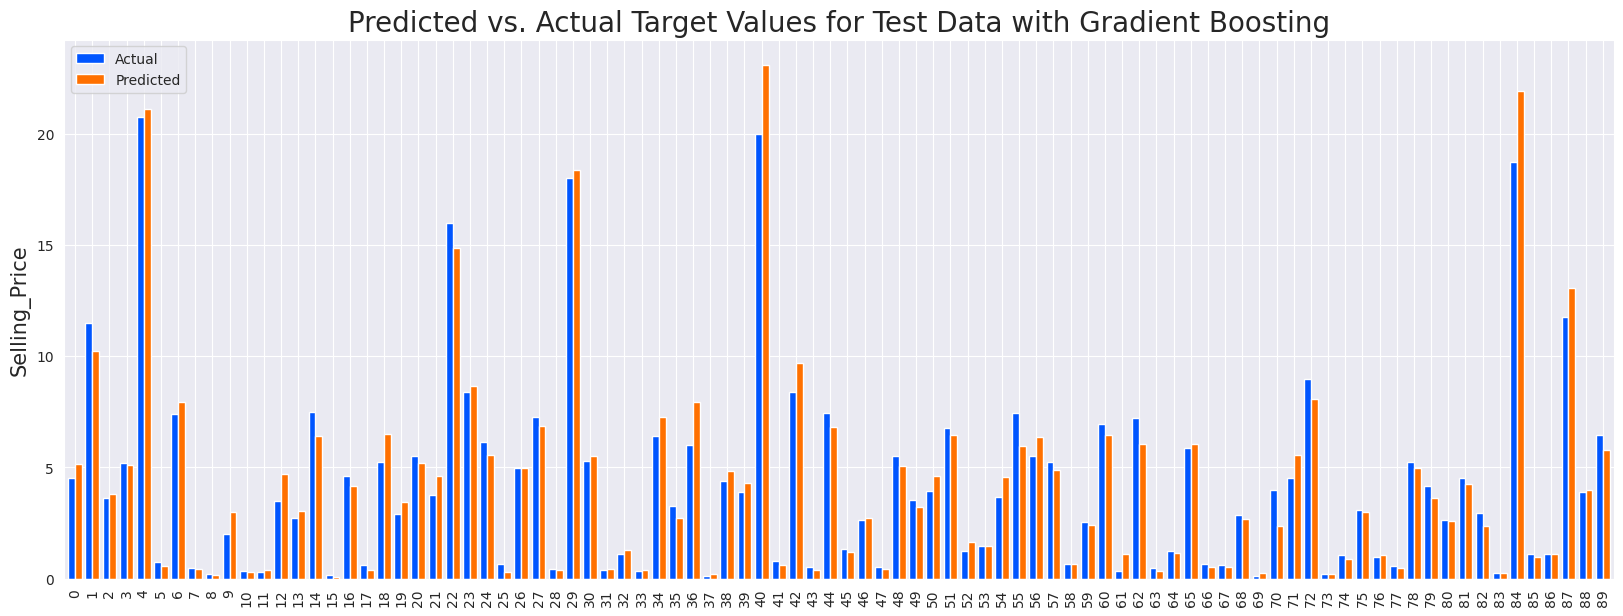

In [249]:
compare_plot(df_comp_3, "Gradient Boosting")

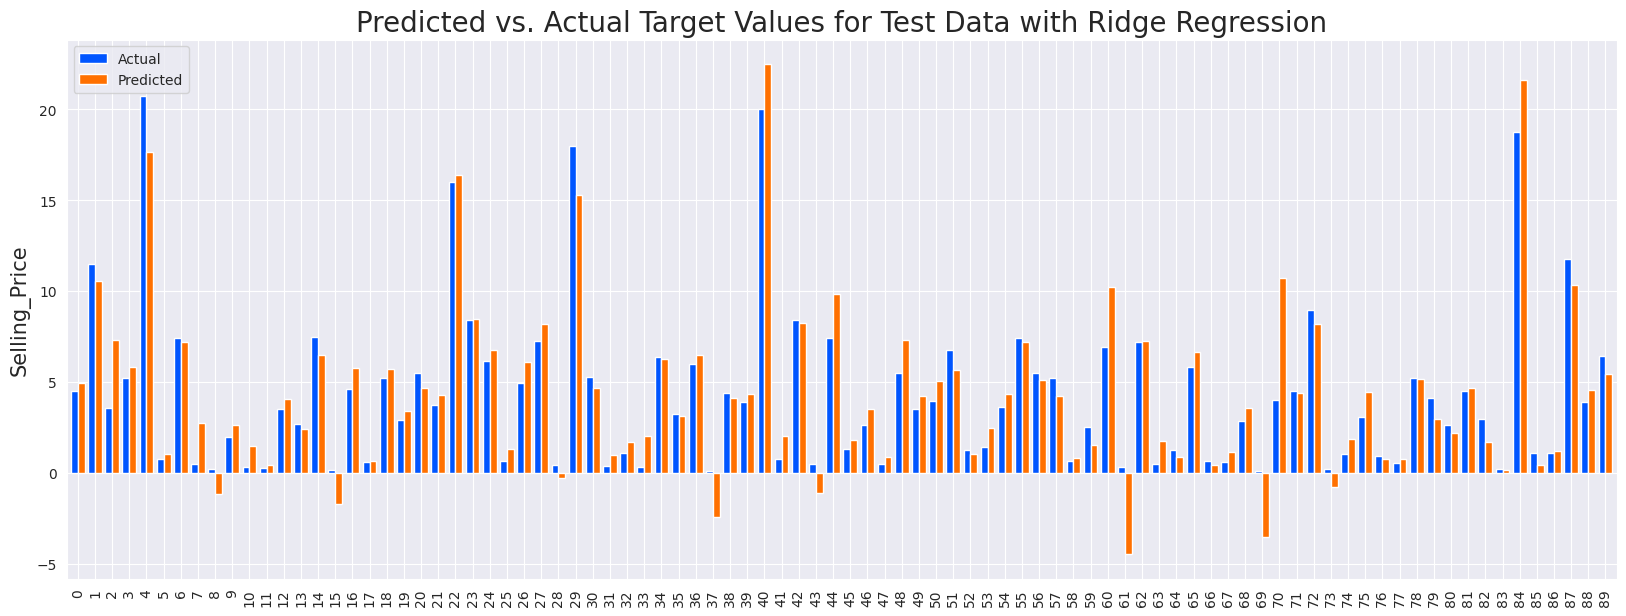

In [250]:
compare_plot(df_comp_4, "Ridge Regression")

In [251]:
def linear_regression_prediction(Age , Present_Price , Kms_Driven , Owner , Fuel_Type_Diesel ,Fuel_Type_Petrol , Seller_Type_Individual , Transmission_Manual):
  scaler_2 = scaler(Age , Present_Price , Kms_Driven , Owner , Fuel_Type_Diesel ,Fuel_Type_Petrol , Seller_Type_Individual , Transmission_Manual)
  a = gb_rs.predict(scaler_2)
  return a[0]

In [252]:
def Gradient_boosting_prediction(Age , Present_Price , Kms_Driven , Owner , Fuel_Type, Seller_Type_Individual , Transmission_Manual):
  Age_dict = {'2003':'16', '2004':'15','2005':'14','2006':'13','2007':'12','2008':'11','2009':'10', '2010':'9', '2011':'8', '2012':'7', '2013':'6', '2014':'5', '2015':'4', '2016':'3', '2017':'2', '2018':'1'}
  if Fuel_Type == 'Diesel':
    Fuel_dict = {'Diesel': '1', 'Petrol': '0'}
  else:
    Fuel_dict = {'Diesel': '0', 'Petrol': '1'}
  Seller_dict = {'Dealer': '0', 'Individual': '1'}
  Transmission_dict = {'Automatic': '0', 'Manual': '1'}
  scaler_2 = scaler(Age_dict[str(Age)] , Present_Price , Kms_Driven , Owner , Fuel_dict['Diesel'] ,Fuel_dict['Petrol'] , Seller_dict[str(Seller_Type_Individual)] , Transmission_dict[str(Transmission_Manual)])
  a = gb_rs.predict(scaler_2)
  return a[0]

In [254]:
def scaler(Age , Present_Price , Kms_Driven , Owner , Fuel_Type_Diesel ,Fuel_Type_Petrol , Seller_Type_Individual , Transmission_Manual):
  data_2 = {'Age': [Age], 'Present_Price': [Present_Price], 'Kms_Driven': [Kms_Driven], 'Owner': [Owner], 'Fuel_Type_Diesel': [Fuel_Type_Diesel], 'Fuel_Type_Petrol': [Fuel_Type_Petrol], 'Seller_Type_Individual': [Seller_Type_Individual], 'Transmission_Manual': [Transmission_Manual]}
  aaa = pd.DataFrame(data_2)
  scaler = StandardScaler()
  scaler.fit(X_train)
  a = scaler.transform(aaa)
  return a

In [255]:
Gradient_boosting_prediction(2005, 13.6 , 10980 , 0 , 'Diesel' , 'Dealer' , 'Automatic')

7.828937746296819